In [5]:
pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 33.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [1]:
#Load in the the essentials 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df =pd.read_csv('https://raw.githubusercontent.com/amirkfard/Bizopt/main/advertising.csv')
df.head(10)

,Date,TV,Radio,Newspaper,Sales
0,"Thursday, January 1, 2015",230.1,37.8,69.2,22.1
1,"Thursday, January 8, 2015",44.5,39.3,45.1,10.4
2,"Thursday, January 15, 2015",17.2,45.9,69.3,9.3
3,"Thursday, January 22, 2015",151.5,41.3,58.5,18.5
4,"Thursday, January 29, 2015",180.8,10.8,58.4,12.9
5,"Thursday, February 5, 2015",8.7,48.9,75.0,7.2
6,"Thursday, February 12, 2015",57.5,32.8,23.5,11.8
7,"Thursday, February 19, 2015",120.2,19.6,11.6,13.2
8,"Thursday, February 26, 2015",8.6,2.1,1.0,4.8
9,"Thursday, March 5, 2015",199.8,2.6,21.2,10.6


In [39]:
df.sum()

Date         Thursday, January 1, 2015Thursday, January 8, ...
TV                                                     51010.5
Radio                                                   8404.8
Newspaper                                              13603.8
Sales                                                   5057.5
dtype: object

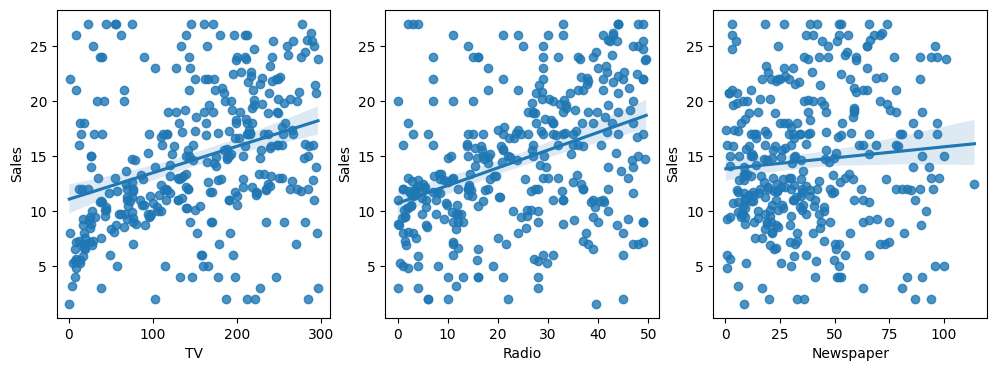

In [6]:
# create subplots to look at the linearity of the data with the target variable
fig, axes  = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
for i,channel in enumerate(['TV','Radio','Newspaper']):
    axes[i] = sns.regplot(data=df,x=channel,y='Sales',ax=axes[i])

<ipython-input-7-374b822980ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

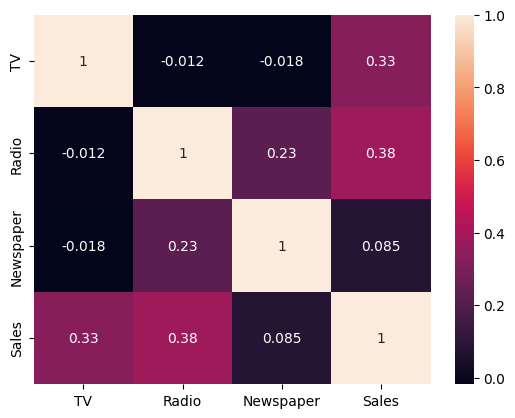

In [7]:
# lets check the correlation between the variables 
sns.heatmap(df.corr(),annot=True)

In [8]:
#Define your independent and target variables
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

# split the data and train the model 
X_train,X_test, y_train, y_test = train_test_split(X,y)
model = LinearRegression()
model.fit(X_train, y_train)

#get the coefficients, predictions, and intercept 
predictions =  model.predict(X_test)
coefficients = model.coef_
intercept = model.intercept_

#create a dataframe
pd.DataFrame(zip(X.columns,coefficients),columns=['channel','coefficients'])

,channel,coefficients
0,TV,0.024186
1,Radio,0.180208
2,Newspaper,-0.009797


In [101]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver('SCIP')

infinity = solver.infinity()

# x and y are integer non-negative variables.
T = solver.NumVar(0.0, infinity, 'TV')
R = solver.NumVar(0.0, infinity, 'Radio')
N = solver.NumVar(0.0, infinity, 'Newspaper')

print('Number of variables =', solver.NumVariables())




Number of variables = 3


In [102]:
T_price = 200
R_price = 1000
N_price = 50

In [103]:

solver.Add(T * T_price + R * R_price + N * N_price <= 60000)

solver.Add(T  >= 3 * R)

solver.Add(N * N_price >= 5000)

print('Number of constraints =', solver.NumConstraints())


Number of constraints = 3


In [104]:

# Maximize objective
solver.Maximize(coefficients[0] * T + coefficients[1] * R + coefficients[2] * N + intercept)

In [105]:
status = solver.Solve()

In [106]:
if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
    print('TV =', T.solution_value())
    print('Radio =', R.solution_value())
    print('Newspaper =', N.solution_value())
else:
    print('The problem does not have an optimal solution.')

Solution:
Objective value = 14.715454247954249
TV = 103.125
Radio = 34.375
Newspaper = 100.0


In [107]:
T_budget = T.solution_value() * T_price
R_budget = R.solution_value() * T_price
N_budget = N.solution_value() * T_price

print('TV Budget =', T_budget)
print('Radio Budget =', R_budget)
print('Newspaper Budget=', N_budget)

TV Budget = 20625.0
Radio Budget = 6875.0
Newspaper Budget= 20000.0


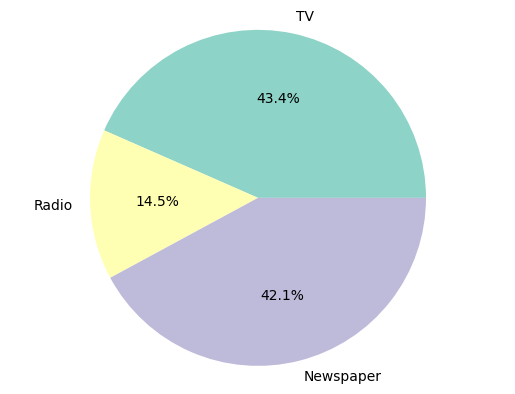

In [109]:
# data to plot
n_groups = 3
budgets = (T_budget, R_budget, N_budget)

# data to plot
budgets = [T_budget, R_budget, N_budget]

# create labels
budget_labels = ['TV', 'Radio', 'Newspaper']

# create a color palette
colors = sns.color_palette('Set3')

plt.pie(budgets, labels = budget_labels, colors = colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

NameError: ignored